# Experiments for the Eikonal equation in a d-dimensional cube

In [1]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import numpy as np
from time import time as t

import sys
# setting path
sys.path.append('../')

from visualization.plots_cube import plot_2d_proj
from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD
from PointSampling.Cube import data_gen_cube
from NeuralNetworks.NNs import FCFF_3L, FCFF_4L

#Right-hand-side of the PDE
def f(X):    
    return 1

#Boundary condition
def g(X):    
    return 0


training_params = {
    'numerical_scheme': Eikonal_sq_LF_multiD,

    'f': f,
    'g': g,
    'c': None,
    
    'beta': 0.,  ## parameter for the +u_i term
    
    'lambda': 1. #weight parameter for the boundary loss
    }

n_experiments_rep = 5

In [2]:
# Dimension of the d-dimensional cube for each experiment
dim_list = 3*[5] + 3*[8]
# Architecture in each experiment
arch_list = [[30,30], 
             [30,30,30],
             [30,30,30],
             [40,40], 
             [40,40,40], 
             [40,40,40]]

n_experiments = len(dim_list)
side_length = 6.


# Parameters for each experiment
delta_list = [[.7, .3, .1, .05]]*n_experiments
alpha_list = [[2.5, 2., 1., .5]]*n_experiments
rounds = len(delta_list[0])

N_col_list = [[200]*rounds]*n_experiments
N_b_list = [[80]*rounds]*n_experiments

num_iterations_list = [[2000, 2000, 2000, 2000],
                       #[2000, 2000, 2000, 2000],
                       [2000, 2500, 3000, 5000],
                       [2000, 2500, 3000, 5000],
                       [3000, 3000, 3000, 3000],
                       [3000, 3000, 3000, 3000],
                       [3000, 4000, 5000, 7000]]    

weight decay


100%|██████████| 5000/5000 [00:52<00:00, 94.86it/s] 
C:\Users\usuario\anaconda3\envs\FD_PINNs\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


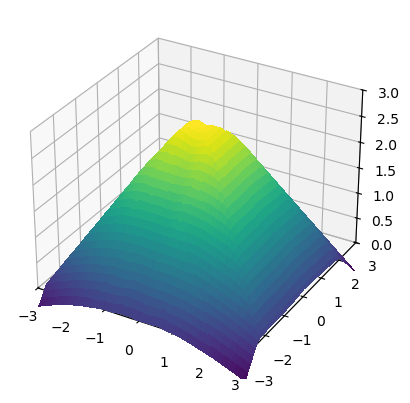

weight decay


100%|██████████| 5000/5000 [00:39<00:00, 126.45it/s]


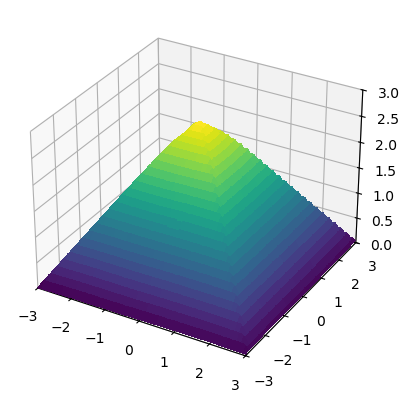

weight decay


100%|██████████| 5000/5000 [00:43<00:00, 113.66it/s]


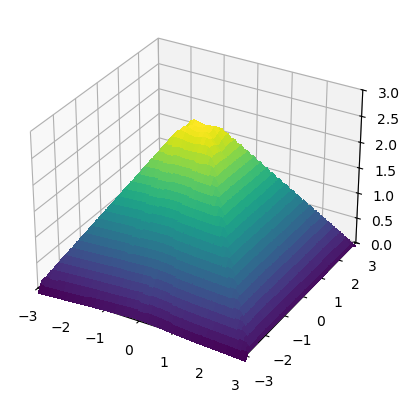

weight decay


100%|██████████| 5000/5000 [00:50<00:00, 99.78it/s] 


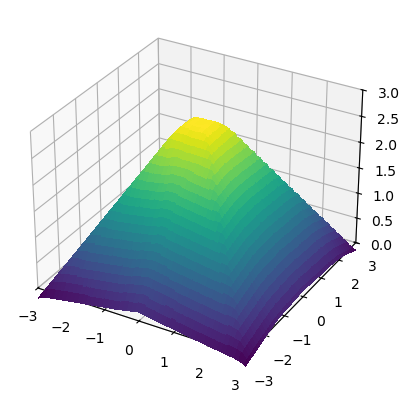

weight decay


100%|██████████| 5000/5000 [00:48<00:00, 104.08it/s]


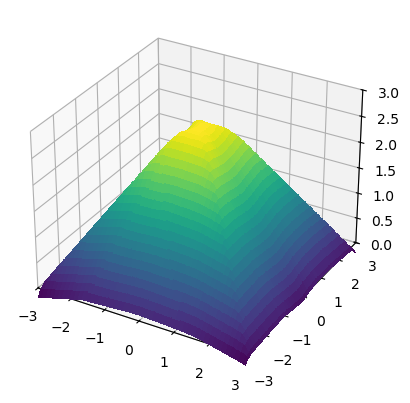

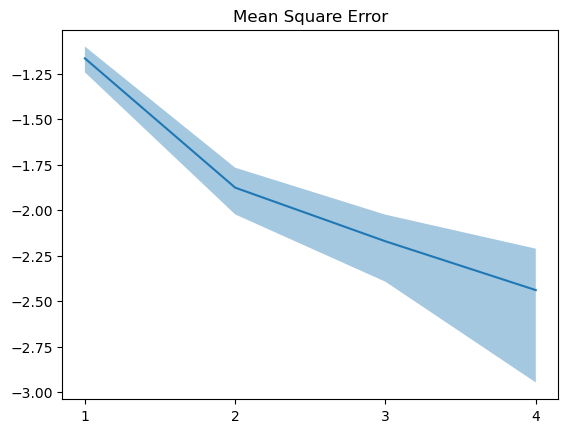

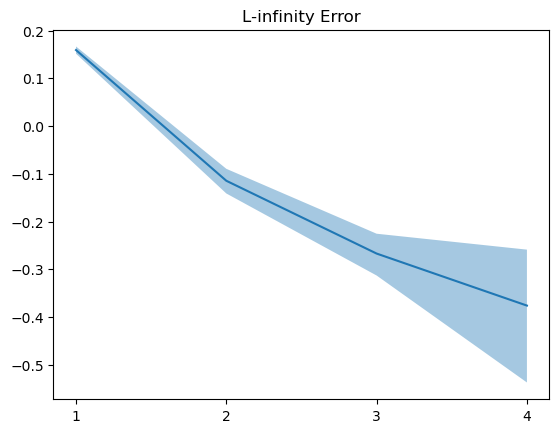

In [3]:
from Training.training import train
from error_test.cube_error import error_cube

MSE_history = torch.zeros([n_experiments, n_experiments_rep, rounds])
L_inf_error_history = torch.zeros([n_experiments, n_experiments_rep, rounds])
run_times = torch.zeros([n_experiments, n_experiments_rep])

#for j in range(n_experiments):
for j in range(2,3):
    
    for k in range(n_experiments_rep):
        
        domain = data_gen_cube(side_length, dim_list[j])
        
        if len(arch_list[j]) == 2:        
            NN = FCFF_3L([dim_list[j]] + arch_list[j])
        else:
            NN = FCFF_4L([dim_list[j]] + arch_list[j])
        
        training_params['optimizer'] = optim.SGD(NN.parameters(), lr = .02, momentum = .2)

        if j==2:
            print('weight decay')
            training_params['optimizer'] = optim.SGD(NN.parameters(), lr = .02, weight_decay=1e-5, momentum = .2)
        
        
        time = 0.
        
        for i in range(rounds):
            
            training_params['alpha'] = alpha_list[j][i]
            training_params['delta'] = delta_list[j][i]
            
            training_params['n_coloc_points'] = N_col_list[j][i]
            training_params['n_boundary_points'] = N_b_list[j][i]
            training_params['num_iterations'] = num_iterations_list[j][i]
            
            t0 = t()
            total_loss, PDE_loss, boundary_loss = train(NN, domain, training_params)
            time += t() - t0
            
            MC_points = int(1e6) # Number of grid points for comparison with the ground truth
            MSE, L_inf = error_cube(NN, side_length, MC_points)
            
            MSE_history[j,k,i] = MSE
            L_inf_error_history[j,k,i] = L_inf
        
        run_times[j,k] = time

        X_axis = 0
        Y_axis = 1
        plot_2d_proj(X_axis, Y_axis, NN, 100, side_length)
    
    plt.plot(np.arange(rounds), MSE_history[j].mean(0).log10())
    plt.fill_between(np.arange(rounds),
                     (MSE_history[j].mean(0) - MSE_history[j].std(0)).log10(),
                     (MSE_history[j].mean(0) + MSE_history[j].std(0)).log10(),
                     alpha = .4
                    )
    plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
    plt.title('Mean Square Error')
    plt.show()
    
    plt.plot(np.arange(rounds), L_inf_error_history[j].mean(0).log10())
    plt.fill_between(np.arange(rounds),
                     (L_inf_error_history[j].mean(0) - L_inf_error_history[j].std(0)).log10(),
                     (L_inf_error_history[j].mean(0) + L_inf_error_history[j].std(0)).log10(),
                     alpha = .4
                    )
    plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
    plt.title('L-infinity Error')
    plt.show()


MSE_average = MSE_history.mean(1)
MSE_std = MSE_history.std(1)

Linf_average = L_inf_error_history.mean(1)
Linf_std = L_inf_error_history.std(1)

run_time_avg = run_times.mean(1) 


In [4]:
run_time_avg = run_times.mean(1) 

import pandas as pd
import numpy as np

training_features = pd.DataFrame({'Dimension': dim_list,
                               'Architecture': arch_list,
                               'delta': delta_list,
                               'alpha': alpha_list,
                               'N': N_col_list,
                               'N_b': N_b_list,
                               'Iterations': num_iterations_list})

run_T = pd.DataFrame({'Runtime (s)': np.array(run_time_avg)}).astype('int')

results_MSE = pd.DataFrame(np.array(MSE_average))
results_Linf = pd.DataFrame(np.array(Linf_average))


display('Mean Square Error', training_features.join(results_MSE).join(run_T).transpose())
display('L-infinity Error', training_features.join(results_Linf).join(run_T).transpose())


#One table

MSE = np.array(MSE_history[:,:,-1])
L_inf_error = np.array(L_inf_error_history[:,:,-1])

data_MSE = pd.DataFrame(MSE.transpose())
means_MSE = data_MSE.mean()
stds_MSE = data_MSE.std()

data_Linf = pd.DataFrame(L_inf_error.transpose())
means_Linf = data_Linf.mean()
stds_Linf = data_Linf.std()

summary_df = pd.DataFrame({
    'MSE': means_MSE.round(3).astype(str) + ' ± ' + stds_MSE.round(3).astype(str),
    'L_inf': means_Linf.round(3).astype(str) + ' ± ' + stds_Linf.round(3).astype(str)
})

display(training_features.join(summary_df).join(run_T).transpose())

'Mean Square Error'

,0,1,2,3,4,5
Dimension,5,5,5,8,8,8
Architecture,"[30, 30]","[30, 30, 30]","[30, 30, 30]","[40, 40]","[40, 40, 40]","[40, 40, 40]"
delta,"[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]"
alpha,"[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]"
N,"[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]"
N_b,"[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]"
Iterations,"[2000, 2000, 2000, 2000]","[2000, 2500, 3000, 5000]","[2000, 2500, 3000, 5000]","[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]","[3000, 4000, 5000, 7000]"
0,0.0,0.0,0.068278,0.0,0.0,0.0
1,0.0,0.0,0.013289,0.0,0.0,0.0
2,0.0,0.0,0.006739,0.0,0.0,0.0


'L-infinity Error'

,0,1,2,3,4,5
Dimension,5,5,5,8,8,8
Architecture,"[30, 30]","[30, 30, 30]","[30, 30, 30]","[40, 40]","[40, 40, 40]","[40, 40, 40]"
delta,"[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]"
alpha,"[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]"
N,"[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]"
N_b,"[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]"
Iterations,"[2000, 2000, 2000, 2000]","[2000, 2500, 3000, 5000]","[2000, 2500, 3000, 5000]","[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]","[3000, 4000, 5000, 7000]"
0,0.0,0.0,1.442493,0.0,0.0,0.0
1,0.0,0.0,0.768091,0.0,0.0,0.0
2,0.0,0.0,0.540745,0.0,0.0,0.0


,0,1,2,3,4,5
Dimension,5,5,5,8,8,8
Architecture,"[30, 30]","[30, 30, 30]","[30, 30, 30]","[40, 40]","[40, 40, 40]","[40, 40, 40]"
delta,"[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]","[0.7, 0.3, 0.1, 0.05]"
alpha,"[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]","[2.5, 2.0, 1.0, 0.5]"
N,"[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]"
N_b,"[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]"
Iterations,"[2000, 2000, 2000, 2000]","[2000, 2500, 3000, 5000]","[2000, 2500, 3000, 5000]","[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]","[3000, 4000, 5000, 7000]"
MSE,0.0 ± 0.0,0.0 ± 0.0,0.004 ± 0.003,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
L_inf,0.0 ± 0.0,0.0 ± 0.0,0.421 ± 0.13,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Runtime (s),0,0,117,0,0,0


In [5]:
print(training_features[['Dimension', 'Architecture', 'Iterations']].join(summary_df).join(run_T).to_latex())

\begin{tabular}{lrllllr}
\toprule
 & Dimension & Architecture & Iterations & MSE & L_inf & Runtime (s) \\
\midrule
0 & 5 & [30, 30] & [2000, 2000, 2000, 2000] & 0.0 ± 0.0 & 0.0 ± 0.0 & 0 \\
1 & 5 & [30, 30, 30] & [2000, 2500, 3000, 5000] & 0.0 ± 0.0 & 0.0 ± 0.0 & 0 \\
2 & 5 & [30, 30, 30] & [2000, 2500, 3000, 5000] & 0.004 ± 0.003 & 0.421 ± 0.13 & 117 \\
3 & 8 & [40, 40] & [3000, 3000, 3000, 3000] & 0.0 ± 0.0 & 0.0 ± 0.0 & 0 \\
4 & 8 & [40, 40, 40] & [3000, 3000, 3000, 3000] & 0.0 ± 0.0 & 0.0 ± 0.0 & 0 \\
5 & 8 & [40, 40, 40] & [3000, 4000, 5000, 7000] & 0.0 ± 0.0 & 0.0 ± 0.0 & 0 \\
\bottomrule
\end{tabular}



<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:39: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:39: SyntaxWarning: invalid escape sequence '\l'
C:\Users\usuario\AppData\Local\Temp\ipykernel_19692\499299695.py:19: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
C:\Users\usuario\AppData\Local\Temp\ipykernel_19692\499299695.py:39: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')


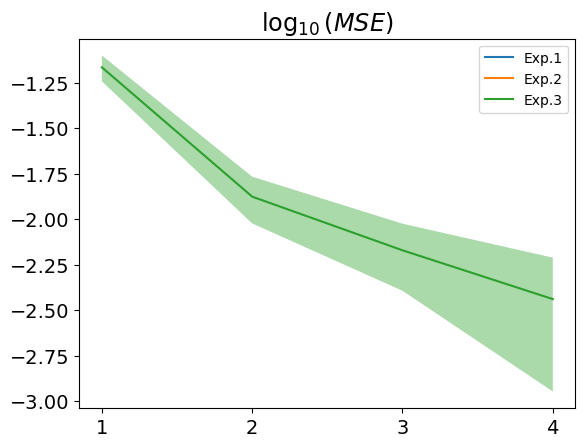

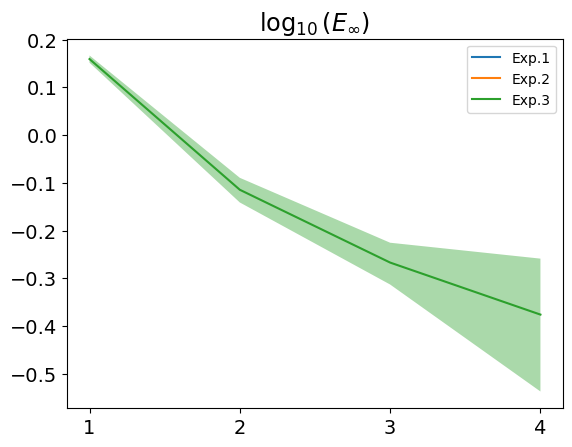

In [6]:
from mpl_toolkits.axes_grid1 import host_subplot

ax = host_subplot(111)
for i in range(0,3):
    x = np.arange(rounds) + 1
    
    text = 'Exp.' + str(i+1)
    
    ax.plot(x, 
            MSE_history[i].mean(0).log10(), 
            label = text)
    ax.fill_between(x,
                   (MSE_history[i].mean(0) - MSE_history[i].std(0)).log10(),
                   (MSE_history[i].mean(0) + MSE_history[i].std(0)).log10(),
                   alpha = .4)
    ax.set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
plt.legend()
plt.show()

ax = host_subplot(111)
for i in range(0,3):
    L_inf_log10 = torch.log10(L_inf_error_history[i])
    
    text = 'Exp.' + str(i+1)
    
    ax.plot(x,
            L_inf_error_history[i].mean(0).log10(), 
            label = text)
    ax.fill_between(x,
                   (L_inf_error_history[i].mean(0) - L_inf_error_history[i].std(0)).log10(),
                   (L_inf_error_history[i].mean(0) + L_inf_error_history[i].std(0)).log10(),
                   alpha = .4)
    ax.set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')
plt.legend()
plt.show()